# Imports

In [1]:
import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

# 주가 데이터

In [50]:
# 주가 URL
samsung_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_for_regression.xlsx'
lg_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_066570_LG%EC%A0%84%EC%9E%90_200601-210416.xlsx'
yg_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_122870_YG_200101-210416.xlsx'
jyp_url = 'https://github.com/KyoungmiKwon/Bigdata_Training_at_ITwill/raw/main/Team_Project/B05_KM_StockPrice_035900_JYP_200101-210416.xlsx'

In [51]:
# 주가 데이터 불러오기
samsung_stock = pd.read_excel(samsung_url, header=0)
lg_stock = pd.read_excel(lg_url, header=0)
yg_stock = pd.read_excel(yg_url, header=0)
jyp_stock = pd.read_excel(jyp_url, header=0)

# 삼성

In [5]:
samsung_stock[:3]

,Date,Open,High,Low,Close,Volume,Change
0,1997-05-03,1090,1093,1077,1087,67197,NaN
1,1997-05-06,1086,1093,1081,1092,93290,0.00460
2,1997-05-07,1084,1088,1077,1085,67110,-0.00641


## 정규화

In [6]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # [시가, 고가, 저가, 종가, 거래량]
samsung_scaled = scaler.fit_transform(samsung_stock[scale_cols])
samsung_scaled = pd.DataFrame(samsung_scaled)
samsung_scaled.columns = scale_cols
samsung_scaled['Date'] = samsung_stock['Date']

In [7]:
# 역 minmax 스케일링
# 정규화된 종가 데이터 -> 원래 종가
def reverse_min_max_scaling(org_x, x): 
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [8]:
def make_dataset(data, label, window_size=20):  #> 데이터 셋 window_size 수 만큼의 일주가 데이터로 예측 하기위해 dataset 나눔.
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))   # 예측하고자 하는 날의 전날부터 20일전까지의 주가 데이터
        label_list.append(np.array(label.iloc[i+window_size]))      # 예측하고자 하는 날의 label(Close:종가) 데이터
    return np.array(feature_list), np.array(label_list)

## LSTM some stock data / 4 feature & 5 feature

In [16]:
# 삼성 5 level 주가 기사
filepath = '/content/stock_label_5.xlsx'
sentiment_data = pd.read_excel(filepath, usecols=['Date', 'Samsung_Sentiment'])

In [17]:
sentiment_data

,Date,Samsung_Sentiment
0,2020-01-02,0
1,2020-01-03,0
2,2020-01-06,0
3,2020-01-07,0
4,2020-01-08,0
...,...,...
315,2021-04-12,-2
316,2021-04-13,1
317,2021-04-14,0
318,2021-04-15,1


In [18]:
# 스케일링된 데이터에 합치기, nan값(기사가 없는 날짜)은 0 으로 대체
samsung_scaled = samsung_scaled.merge(sentiment_data, left_on='Date', right_on='Date', how='left').replace(np.nan, 0)

In [19]:
# 감성 값을 가지고 있는 기사 날짜로만 함
samsung_scaled = samsung_scaled[samsung_scaled['Date']>='2020-06-01']

In [20]:
samsung_scaled

,Open,High,Low,Close,Volume,Date,Samsung_Sentiment
0,0.562569,0.528926,0.565363,0.559603,0.187686,2020-06-01,1.0
1,0.564784,0.532025,0.567598,0.561816,0.157774,2020-06-02,1.0
2,0.573643,0.568182,0.577654,0.596118,0.545453,2020-06-03,2.0
3,0.617940,0.588843,0.610056,0.597225,0.445377,2020-06-04,1.0
4,0.602436,0.577479,0.603352,0.607184,0.251850,2020-06-05,2.0
...,...,...,...,...,...,...,...
222,0.918051,0.857438,0.920670,0.904839,0.154306,2021-04-22,0.0
223,0.906977,0.856405,0.911732,0.909265,0.197163,2021-04-23,0.0
224,0.918051,0.862603,0.922905,0.917011,0.171527,2021-04-26,0.0
225,0.921373,0.860537,0.921788,0.910371,0.143307,2021-04-27,0.0


In [21]:
TEST_SIZE = 20    # 최근 20일간의 주가를 예측하겠다
WINDOW_SIZE = 10   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 20일간의 데이터 -> test 데이터

In [22]:
#feature_cols = ['Open']
feature_cols_4 = ['Open', 'High', 'Low', 'Volume']                         # 특성 값 4개
feature_cols_5 = ['Open', 'High', 'Low', 'Volume', 'Samsung_Sentiment']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature_4 = train[feature_cols_4]
train_feature_5 = train[feature_cols_5]
train_label = train[label_cols]

# train dataset 생성
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_4 = test[feature_cols_4]
test_feature_5 = test[feature_cols_5]
test_label = test[label_cols]

test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)

In [ ]:
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal'))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('some_stock_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=200, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                    callbacks=[early_stop, checkpoint])

In [24]:
# 특성 4가지를 가지고 예측한 주가 15일치 = (test_size - window_size)
predicted_stock_4 = model_4.predict(test_feature_4)

In [ ]:
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal' ))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('some_stock_5.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=200, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

In [26]:
# 특성 5가지를 가지고 예측한 주가 15일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

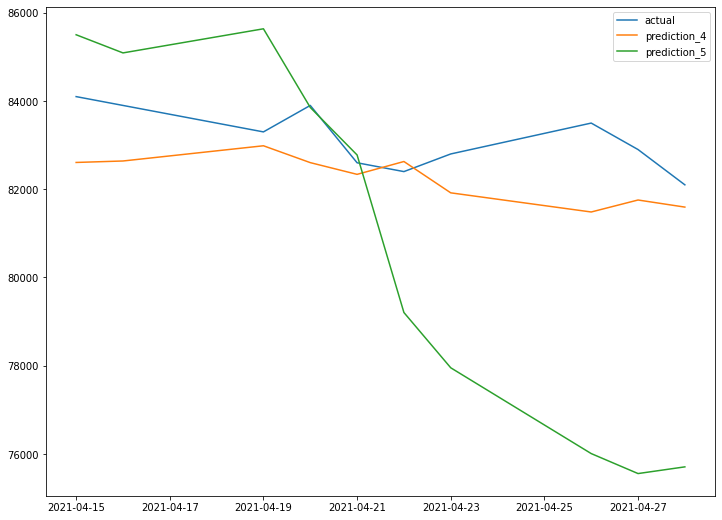

In [28]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]
plt.figure(figsize=(12, 9))
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_4), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4), label = 'prediction_4')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), label = 'prediction_5')
plt.legend()
plt.show()

In [29]:
# 특성을 4가지로 한 모델 평가 -> loss = mse = 1.2590e-04 (relu) /  
model_4.evaluate(test_feature_4, test_label_4)

1/1 [==============================] - 0s 22ms/step - loss: 1.4840e-04


0.00014839509094599634

In [30]:
# 특성을 5가지로 한 모델 평가 -> loss = mse = 5.6077e-04 (relu) / 
model_5.evaluate(test_feature_5, test_label_5)

1/1 [==============================] - 0s 20ms/step - loss: 0.0024


0.0023700431920588017

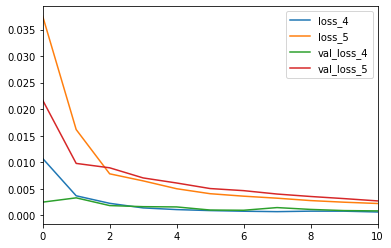

In [31]:
# 손실 함수 그래프

plt.plot(history_4.history['loss'], label='loss_4')
plt.plot(history_5.history['loss'], label='loss_5')
plt.plot(history_4.history['val_loss'], label = 'val_loss_4')
plt.plot(history_5.history['val_loss'], label = 'val_loss_5')

plt.xlim((0, 10))
plt.legend()
plt.show()

## LSTM total stock data  / 4 feature & 5 feature

In [32]:
# 삼성 전체 기사를 가져와서 정규화.
samsung_scaled = scaler.fit_transform(samsung_stock[scale_cols])
samsung_scaled = pd.DataFrame(samsung_scaled)
samsung_scaled.columns = scale_cols
samsung_scaled['Date'] = samsung_stock['Date']

In [33]:
# 스케일링된 데이터에 합치기, nan값(기사가 없는 날짜)은 0 으로 대체
samsung_scaled = samsung_scaled.merge(sentiment_data, left_on='Date', right_on='Date', how='left').replace(np.nan, 0)

In [34]:
samsung_scaled

,Open,High,Low,Close,Volume,Date,Samsung_Sentiment
0,0.012071,0.011291,0.012034,0.005090,0.000744,1997-05-03,0.0
1,0.012027,0.011291,0.012078,0.005145,0.001033,1997-05-06,0.0
2,0.012004,0.011240,0.012034,0.005068,0.000743,1997-05-07,0.0
3,0.011993,0.011188,0.011777,0.004736,0.000804,1997-05-08,0.0
4,0.011717,0.011023,0.011721,0.004847,0.000892,1997-05-09,0.0
...,...,...,...,...,...,...,...
5994,0.918051,0.857438,0.920670,0.904839,0.154306,2021-04-22,0.0
5995,0.906977,0.856405,0.911732,0.909265,0.197163,2021-04-23,0.0
5996,0.918051,0.862603,0.922905,0.917011,0.171527,2021-04-26,0.0
5997,0.921373,0.860537,0.921788,0.910371,0.143307,2021-04-27,0.0


In [35]:
TEST_SIZE = 200    # 최근 200일간의 주가를 예측하겠다
WINDOW_SIZE = 30   # 30일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = samsung_scaled[:-TEST_SIZE]     
test = samsung_scaled[-TEST_SIZE:]      # 최근 200일간의 데이터 -> test 데이터

In [36]:
feature_cols_4 = ['Open', 'High', 'Low', 'Volume']                         # 특성 값 4개
feature_cols_5 = ['Open', 'High', 'Low', 'Volume', 'Samsung_Sentiment']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature_4 = train[feature_cols_4]
train_feature_5 = train[feature_cols_5]
train_label = train[label_cols]

# train dataset 생성
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_4 = test[feature_cols_4]
test_feature_5 = test[feature_cols_5]
test_label = test[label_cols]

test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)

In [37]:
# 특성 4개 모델 생성
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='hard_sigmoid', recurrent_activation='tanh', return_sequences=False))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('total_stock_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=200, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
289/289 [==============================] - 8s 21ms/step - loss: 0.0092 - val_loss: 5.3195e-05

Epoch 00001: val_loss improved from inf to 0.00005, saving model to total_stock_4.h5
Epoch 2/200
289/289 [==============================] - 6s 20ms/step - loss: 9.0484e-05 - val_loss: 8.7292e-05

Epoch 00002: val_loss did not improve from 0.00005
Epoch 3/200
289/289 [==============================] - 6s 20ms/step - loss: 8.8103e-05 - val_loss: 1.5015e-04

Epoch 00003: val_loss did not improve from 0.00005
Epoch 4/200
289/289 [==============================] - 6s 19ms/step - loss: 1.2913e-04 - val_loss: 4.4515e-05

Epoch 00004: val_loss improved from 0.00005 to 0.00004, saving model to total_stock_4.h5
Epoch 5/200
289/289 [==============================] - 6s 20ms/step - loss: 1.2678e-04 - val_loss: 5.2056e-05

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/200
289/289 [==============================] - 6s 20ms/step - loss: 2.1002e-04 - val_loss: 7.8779e-05

Epoch 00006

In [38]:
# 특성 4가지를 가지고 예측한 주가 170일치 = (test_size - window_size)
predicted_stock_4 = model_4.predict(test_feature_4)

In [ ]:
# 특성 5개 모델 생성
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='hard_sigmoid', recurrent_activation='tanh', return_sequences=False))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('total_stock_5.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=200, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

In [40]:
# 특성 5가지를 가지고 예측한 주가 170일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

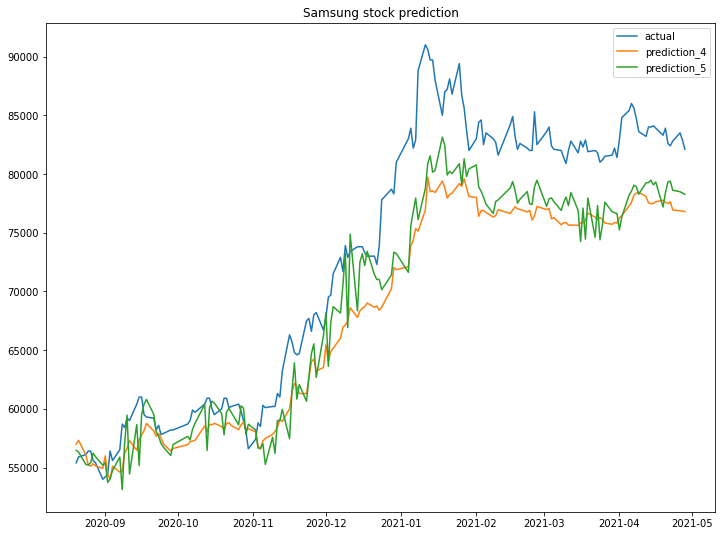

In [41]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]
plt.figure(figsize=(12, 9))
plt.title('Samsung stock prediction')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], test_label_4), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4), label = 'prediction_4')
plt.plot(time_list, reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), label = 'prediction_5')
plt.legend()
plt.show()

In [42]:
# 특성을 4가지로 한 모델 평가 -> loss = mse = 2.6468e-04
model_4.evaluate(test_feature_4, test_label_4)

6/6 [==============================] - 0s 5ms/step - loss: 0.0038


0.003834935836493969

In [43]:
# 특성을 5가지로 한 모델 평가 -> loss = mse = 7.6713e-04
model_5.evaluate(test_feature_5, test_label_5)

6/6 [==============================] - 0s 6ms/step - loss: 0.0027


0.00272005726583302

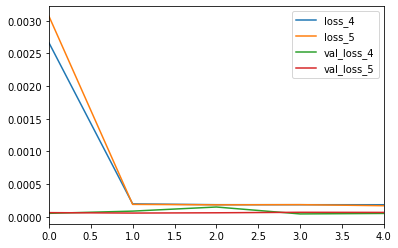

In [44]:
plt.plot(history_4.history['loss'], label='loss_4')
plt.plot(history_5.history['loss'], label='loss_5')
plt.plot(history_4.history['val_loss'], label = 'val_loss_4')
plt.plot(history_5.history['val_loss'], label = 'val_loss_5')

plt.xlim((0, 4))
plt.legend()
plt.show()

## 변동률

In [45]:
recent_data_4 = np.array([samsung_scaled[len(samsung_scaled)- WINDOW_SIZE : ].drop(['Close', 'Date', 'Samsung_Sentiment'], axis=1)])
recent_data_5 = np.array([samsung_scaled[len(samsung_scaled)- WINDOW_SIZE : ].drop(['Close', 'Date'], axis=1)])

In [46]:
x_4 = np.delete(reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4), 0)
x_5 = np.delete(reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5), 0)

In [47]:
x_4 = np.append(x_4, reverse_min_max_scaling(samsung_stock['Close'], model_4.predict(recent_data_4)))
x_5 = np.append(x_5, reverse_min_max_scaling(samsung_stock['Close'], model_5.predict(recent_data_5)))

In [48]:
change_4 = ((x_4.reshape((-1)) - reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4).reshape((-1))) / reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_4).reshape((-1)))
change_5 = ((x_5.reshape((-1)) - reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5).reshape((-1))) / reverse_min_max_scaling(samsung_stock['Close'], predicted_stock_5).reshape((-1)))

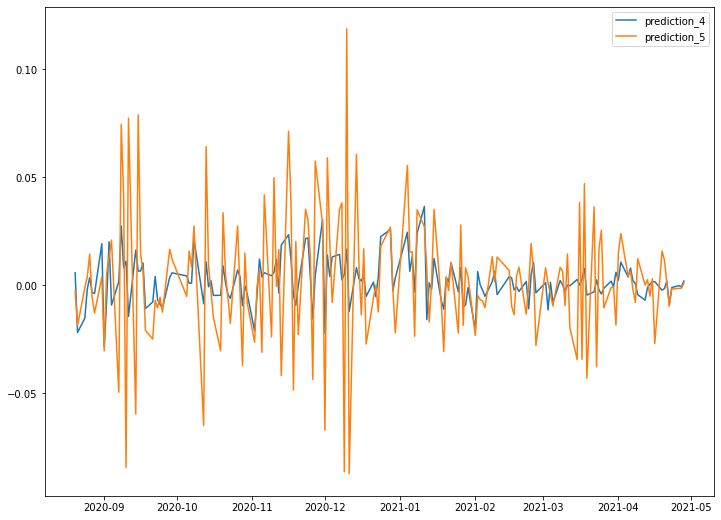

In [49]:
plt.figure(figsize=(12, 9))
plt.plot(time_list, change_4, label = 'prediction_4')
plt.plot(time_list, change_5, label = 'prediction_5')
plt.legend()
plt.show()

# LG

In [53]:
len(lg_stock)

219

## 정규화

In [55]:
scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # [시가, 고가, 저가, 종가, 거래량]
lg_scaled = scaler.fit_transform(lg_stock[scale_cols])
lg_scaled = pd.DataFrame(lg_scaled)
lg_scaled.columns = scale_cols
lg_scaled['Date'] = lg_stock['Date']

## LSTM stock data / 4 feature & 5 feature

In [56]:
# LG 5 level 주가 기사
filepath = '/content/stock_label_5.xlsx'
sentiment_data = pd.read_excel(filepath, usecols=['Date', 'LG_Sentiment'])

In [57]:
sentiment_data

,Date,LG_Sentiment
0,2020-01-02,0
1,2020-01-03,0
2,2020-01-06,0
3,2020-01-07,0
4,2020-01-08,0
...,...,...
315,2021-04-12,-1
316,2021-04-13,1
317,2021-04-14,1
318,2021-04-15,2


In [58]:
# 스케일링된 데이터에 합치기, nan값(기사가 없는 날짜)은 0 으로 대체
lg_scaled = lg_scaled.merge(sentiment_data, left_on='Date', right_on='Date', how='left').replace(np.nan, 0)

In [59]:
# 감성 값을 가지고 있는 기사 날짜로만 함
lg_scaled = lg_scaled[lg_scaled['Date']>='2020-06-01']

In [60]:
lg_scaled

,Open,High,Low,Close,Volume,Date,LG_Sentiment
0,0.000000,0.000000,0.000000,0.000000,0.008110,2020-06-01,-1
1,0.001613,0.011236,0.005882,0.006359,0.021769,2020-06-02,1
2,0.012097,0.021723,0.016807,0.023052,0.048980,2020-06-03,2
3,0.030645,0.026966,0.022689,0.023847,0.025880,2020-06-04,1
4,0.025806,0.026217,0.026891,0.030207,0.022458,2020-06-05,1
...,...,...,...,...,...,...,...
214,0.806452,0.760300,0.819328,0.773450,0.029139,2021-04-12,-1
215,0.786290,0.741573,0.810924,0.781399,0.034207,2021-04-13,1
216,0.842742,0.790262,0.844538,0.813196,0.096225,2021-04-14,1
217,0.830645,0.842697,0.861345,0.896661,0.214453,2021-04-15,2


In [61]:
TEST_SIZE = 20    # 최근 20일간의 주가를 예측하겠다
WINDOW_SIZE = 10   # 5일의 데이터를 기반으로 다음날 주가를 예측하겠다

train = lg_scaled[:-TEST_SIZE]     
test = lg_scaled[-TEST_SIZE:]      # 최근 20일간의 데이터 -> test 데이터

In [62]:
#feature_cols = ['Open']
feature_cols_4 = ['Open', 'High', 'Low', 'Volume']                         # 특성 값 4개
feature_cols_5 = ['Open', 'High', 'Low', 'Volume', 'LG_Sentiment']    # 특성 값 5개
label_cols = ['Close']  # label 데이터(종가)

train_feature_4 = train[feature_cols_4]
train_feature_5 = train[feature_cols_5]
train_label = train[label_cols]

# train dataset 생성
train_feature_4, train_label_4 = make_dataset(train_feature_4, train_label, WINDOW_SIZE)
train_feature_5, train_label_5 = make_dataset(train_feature_5, train_label, WINDOW_SIZE)

# train, validation set 생성
x_train_4, x_valid_4, y_train_4, y_valid_4 = train_test_split(train_feature_4, train_label_4, test_size=0.2)
x_train_5, x_valid_5, y_train_5, y_valid_5 = train_test_split(train_feature_5, train_label_5, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature_4 = test[feature_cols_4]
test_feature_5 = test[feature_cols_5]
test_label = test[label_cols]

test_feature_4, test_label_4 = make_dataset(test_feature_4, test_label, WINDOW_SIZE)
test_feature_5, test_label_5 = make_dataset(test_feature_5, test_label, WINDOW_SIZE)

In [ ]:
model_4 = Sequential()
model_4.add(LSTM(32, input_shape=(train_feature_4.shape[1], train_feature_4.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal'))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('some_stock_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_4 = model_4.fit(x_train_4, y_train_4, epochs=200, batch_size=16, validation_data=(x_valid_4, y_valid_4), 
                    callbacks=[early_stop, checkpoint])

In [64]:
# 특성 4가지를 가지고 예측한 주가 15일치 = (test_size - window_size)
predicted_stock_4 = model_4.predict(test_feature_4)

In [65]:
model_5 = Sequential()
model_5.add(LSTM(32, input_shape=(train_feature_5.shape[1], train_feature_5.shape[2]), activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=False, kernel_initializer='he_normal' ))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_squared_error')  # 손실함수 = mse

# 조기종료
early_stop = EarlyStopping(monitor='val_loss', patience=5)  # 5번 연속 개선이 없으면 조기종료

# best 모델 저장
checkpoint = ModelCheckpoint('some_stock_5.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history_5 = model_5.fit(x_train_5, y_train_5, epochs=200, batch_size=16, validation_data=(x_valid_5, y_valid_5), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
10/10 [==============================] - 3s 49ms/step - loss: 0.1121 - val_loss: 0.0305

Epoch 00001: val_loss improved from inf to 0.03050, saving model to some_stock_5.h5
Epoch 2/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0301 - val_loss: 0.0244

Epoch 00002: val_loss improved from 0.03050 to 0.02441, saving model to some_stock_5.h5
Epoch 3/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0163 - val_loss: 0.0220

Epoch 00003: val_loss improved from 0.02441 to 0.02202, saving model to some_stock_5.h5
Epoch 4/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0126 - val_loss: 0.0195

Epoch 00004: val_loss improved from 0.02202 to 0.01954, saving model to some_stock_5.h5
Epoch 5/200
10/10 [==============================] - 0s 15ms/step - loss: 0.0085 - val_loss: 0.0172

Epoch 00005: val_loss improved from 0.01954 to 0.01717, saving model to some_stock_5.h5
Epoch 6/200
10/10 [==============================] - 0s 15m

In [66]:
# 특성 5가지를 가지고 예측한 주가 15일치 = (test_size - window_size)
predicted_stock_5 = model_5.predict(test_feature_5)

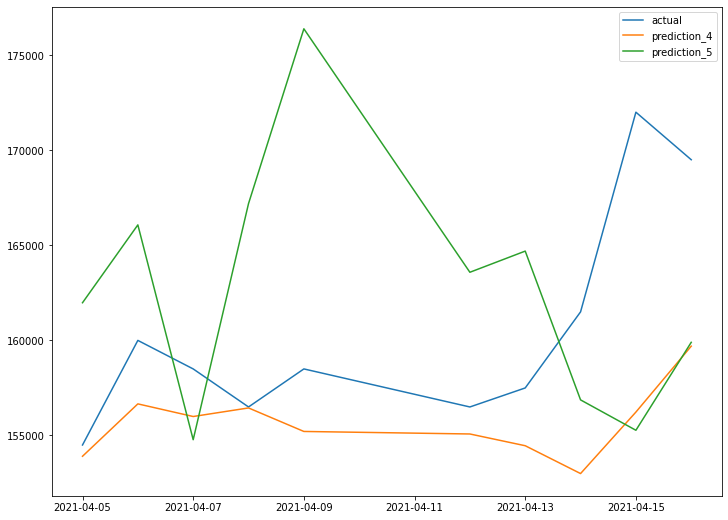

In [67]:
time_list = test.Date[-(TEST_SIZE-WINDOW_SIZE):]
plt.figure(figsize=(12, 9))
plt.plot(time_list, reverse_min_max_scaling(lg_stock['Close'], test_label_4), label = 'actual')
plt.plot(time_list, reverse_min_max_scaling(lg_stock['Close'], predicted_stock_4), label = 'prediction_4')
plt.plot(time_list, reverse_min_max_scaling(lg_stock['Close'], predicted_stock_5), label = 'prediction_5')
plt.legend()
plt.show()

In [68]:
# 특성을 4가지로 한 모델 평가 -> loss = mse = 1.2590e-04 (relu) /  
model_4.evaluate(test_feature_4, test_label_4)

1/1 [==============================] - 0s 22ms/step - loss: 0.0029


0.0028867193032056093

In [69]:
# 특성을 5가지로 한 모델 평가 -> loss = mse = 5.6077e-04 (relu) / 
model_5.evaluate(test_feature_5, test_label_5)

1/1 [==============================] - 0s 19ms/step - loss: 0.0065


0.006547681987285614

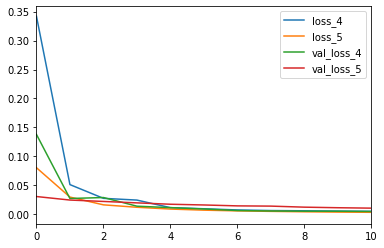

In [70]:
# 손실 함수 그래프
plt.plot(history_4.history['loss'], label='loss_4')
plt.plot(history_5.history['loss'], label='loss_5')
plt.plot(history_4.history['val_loss'], label = 'val_loss_4')
plt.plot(history_5.history['val_loss'], label = 'val_loss_5')

plt.xlim((0, 10))
plt.legend()
plt.show()